# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake model exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Import the lake model function from dps_lake_model.py**

**2) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes as specified above**



In [1]:
from dps_lake_model import lake_model, get_antropogenic_release

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
model = Model('lakeproblem', function=lake_model)
model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
model.levers = [RealParameter('c1', -2, 2),
                            RealParameter('c2', -2, 2),
                            RealParameter('r1', 0, 2),
                            RealParameter('r2', 0, 2),
                            RealParameter('w1', 0, 1)]
#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)]

## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

Take the model interface developed in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:
* change the epsilon values between 0.01 and 0.1, what changes, why?
* change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference? You can use  convergence as explained in assignment 7 for this

In [2]:
# 1000 experiments
with MultiprocessingEvaluator(model) as evaluator:
    results0 = evaluator.optimize(nfe=1000, epsilons=[0.01, 0.01, 0.01, 0.01])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 495/1000 nfe
[MainProcess/INFO] generation 10: 993/1000 nfe
[MainProcess/INFO] optimization completed, found 84 solutions
[MainProcess/INFO] terminating pool


In [3]:
# 1000 experiments
with MultiprocessingEvaluator(model) as evaluator:
    results1 = evaluator.optimize(nfe=1000, epsilons=[0.1, 0.1, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 496/1000 nfe
[MainProcess/INFO] generation 10: 992/1000 nfe
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


In [4]:
# 10,000 experiments
with MultiprocessingEvaluator(model) as evaluator:
    results2 = evaluator.optimize(nfe=10000, epsilons=[0.01, 0.01, 0.01, 0.01])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 495/10000 nfe
[MainProcess/INFO] generation 10: 994/10000 nfe
[MainProcess/INFO] generation 15: 1492/10000 nfe
[MainProcess/INFO] generation 20: 1989/10000 nfe
[MainProcess/INFO] generation 25: 2485/10000 nfe
[MainProcess/INFO] generation 30: 2978/10000 nfe
[MainProcess/INFO] generation 35: 3468/10000 nfe
[MainProcess/INFO] generation 40: 3965/10000 nfe
[MainProcess/INFO] generation 45: 4459/10000 nfe
[MainProcess/INFO] generation 50: 4955/10000 nfe
[MainProcess/INFO] generation 55: 5452/10000 nfe
[MainProcess/INFO] generation 60: 5950/10000 nfe
[MainProcess/INFO] generation 65: 6444/10000 nfe
[MainProcess/INFO] generation 70: 6938/10000 nfe
[MainProcess/INFO] generation 75: 7432/10000 nfe
[MainProcess/INFO] generation 80: 7930/10000 nfe
[MainProcess/INFO] generation 85: 8426/10000 nfe
[MainProcess/INFO] generation 90: 8924/10000 nfe
[MainProcess/INFO] generation 95: 9419/10000

In [5]:
# 10,000 experiments
with MultiprocessingEvaluator(model) as evaluator:
    results3 = evaluator.optimize(nfe=10000, epsilons=[0.1, 0.1, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 994/10000 nfe
[MainProcess/INFO] generation 15: 1488/10000 nfe
[MainProcess/INFO] generation 20: 1986/10000 nfe
[MainProcess/INFO] generation 25: 2483/10000 nfe
[MainProcess/INFO] generation 30: 2979/10000 nfe
[MainProcess/INFO] generation 35: 3473/10000 nfe
[MainProcess/INFO] generation 40: 3969/10000 nfe
[MainProcess/INFO] generation 45: 4462/10000 nfe
[MainProcess/INFO] generation 50: 4955/10000 nfe
[MainProcess/INFO] generation 55: 5444/10000 nfe
[MainProcess/INFO] generation 60: 5943/10000 nfe
[MainProcess/INFO] generation 65: 6437/10000 nfe
[MainProcess/INFO] generation 70: 6927/10000 nfe
[MainProcess/INFO] generation 75: 7420/10000 nfe
[MainProcess/INFO] generation 80: 7914/10000 nfe
[MainProcess/INFO] generation 85: 8411/10000 nfe
[MainProcess/INFO] generation 90: 8904/10000 nfe
[MainProcess/INFO] generation 95: 9400/10000

In [6]:
# convergance
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

#specify outcomes  
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

In [7]:
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=1000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 494/1000 nfe
[MainProcess/INFO] generation 10: 985/1000 nfe
[MainProcess/INFO] optimization completed, found 9 solutions
[MainProcess/INFO] terminating pool


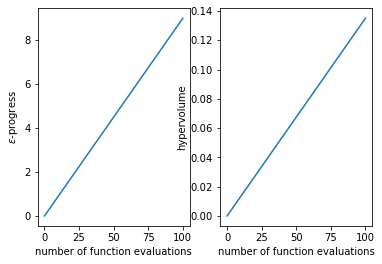

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [9]:
with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=10000, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.1, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 996/10000 nfe
[MainProcess/INFO] generation 15: 1487/10000 nfe
[MainProcess/INFO] generation 20: 1984/10000 nfe
[MainProcess/INFO] generation 25: 2478/10000 nfe
[MainProcess/INFO] generation 30: 2974/10000 nfe
[MainProcess/INFO] generation 35: 3470/10000 nfe
[MainProcess/INFO] generation 40: 3969/10000 nfe
[MainProcess/INFO] generation 45: 4461/10000 nfe
[MainProcess/INFO] generation 50: 4956/10000 nfe
[MainProcess/INFO] generation 55: 5454/10000 nfe
[MainProcess/INFO] generation 60: 5950/10000 nfe
[MainProcess/INFO] generation 65: 6448/10000 nfe
[MainProcess/INFO] generation 70: 6938/10000 nfe
[MainProcess/INFO] generation 75: 7434/10000 nfe
[MainProcess/INFO] generation 80: 7926/10000 nfe
[MainProcess/INFO] generation 85: 8422/10000 nfe
[MainProcess/INFO] generation 90: 8917/10000 nfe
[MainProcess/INFO] generation 95: 9413/10000

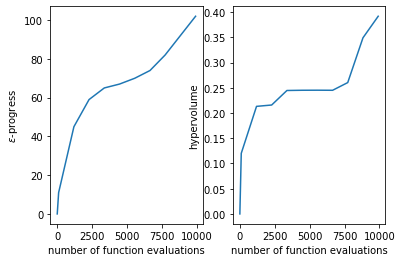

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

With 10,000 nfe there is already a convergence of hypervolume and e-progress is beginning to converge

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.|



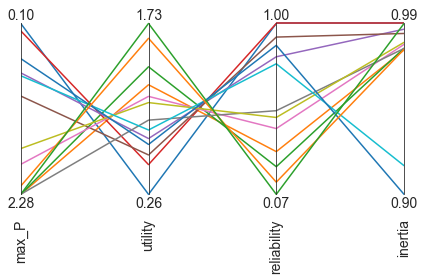

In [11]:
# parallel axis plot
from ema_workbench.analysis import parcoords

outcomes = results.loc[:, ['max_P', 'utility', 'reliability','inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

!! write tradeoffs here !!!

## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**


In [12]:
import pandas as pd

#sort values for 90 % 
df = pd.DataFrame(results)
df.sort_values("reliability", inplace = True)

df

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
12,-0.684821,-0.071241,1.158709,1.387136,0.722704,2.283648,1.734761,0.9900,0.0700
11,-0.416962,0.180799,1.163404,0.097046,0.115917,2.177611,1.606686,0.9760,0.1364
2,-0.488802,0.303434,1.616892,0.249258,0.267371,2.283757,1.361136,0.9766,0.2205
1,-0.437026,0.303434,1.483809,0.249258,0.237261,2.283778,1.206022,0.9757,0.3025
6,-0.407969,0.285581,1.511512,0.147136,0.268857,1.900356,1.105751,0.9787,0.4280
8,-0.407969,0.285581,1.511512,0.147136,0.268857,1.698704,1.052209,0.9798,0.4885
7,-0.416962,0.303434,1.524801,0.257837,0.268857,2.283569,0.900987,0.9765,0.5253
9,-0.416962,0.304553,1.163404,0.070463,0.047258,0.768006,0.815812,0.9131,0.7807
4,-0.416962,0.303434,1.539361,0.075996,0.220264,0.730956,0.742095,0.9869,0.8188
10,-0.416962,0.304553,1.163404,0.070463,0.047258,0.548764,0.691221,0.8976,0.8809


In [13]:
#drop values
new_results = df[df['reliability'] > 0.9] 
new_results = new_results.drop(['max_P','utility','inertia','reliability'],axis=1)
new_results

,c1,c2,r1,r2,w1
5,-0.416962,0.303434,1.536893,0.257837,0.268857
0,0.462148,0.225088,1.532849,0.575082,0.528325
3,-0.416962,0.295478,1.567198,0.437604,0.268857



**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

In [14]:
#create policies
from ema_workbench import Policy

policies = []

for i, policy in new_results.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))

In [15]:
policies

[Policy({'c1': -0.41696218320545486, 'c2': 0.3034335625836155, 'r1': 1.5368926275681691, 'r2': 0.25783734072954834, 'w1': 0.26885713830107494}),
 Policy({'c1': 0.4621480025488937, 'c2': 0.2250878300673837, 'r1': 1.532848750862613, 'r2': 0.57508216624155, 'w1': 0.5283250720876136}),
 Policy({'c1': -0.41696218320545486, 'c2': 0.29547778055670876, 'r1': 1.5671977544605296, 'r2': 0.4376041477155682, 'w1': 0.26885713830107494})]

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [39]:
from ema_workbench import (MultiprocessingEvaluator,
                           perform_experiments)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [166]:
experiments, outcomes = results

We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation is different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel axis plot. Which solutions look like a good compromise policy?**

In [64]:
def stn(results):
    
    max_P = outcomes['max_P']
    utility = outcomes['utility']
    inertia = outcomes['inertia']
    reliability = outcomes['reliability']
    
    stn_max_P = []
    stn_utility = []
    stn_inertia = []
    stn_reliability = []
    
    for i in range(1,int(len(outcomes['max_P'])/1000)+1):
        stn_max_P.append(max_P[(i-1)*1000:i*1000].mean()/max_P[(i-1)*1000:i*1000].std())
        stn_utility.append(utility[(i-1)*1000:i*1000].mean()/utility[(i-1)*1000:i*1000].std())
        stn_inertia.append(inertia[(i-1)*1000:i*1000].mean()/inertia[(i-1)*1000:i*1000].std())
        stn_reliability.append(reliability[(i-1)*1000:i*1000].mean()/reliability[(i-1)*1000:i*1000].std())
        
    return stn_max_P, stn_utility, stn_inertia, stn_reliability

In [71]:
outcome_stn = pd.DataFrame(stn(results)).T

In [80]:
outcome_stn

,0,1,2,3
0,0.951246,1.661237,86.970195,1.220228
1,0.669261,0.925057,121.111337,1.962152
2,0.910572,1.431861,133.769972,1.348427


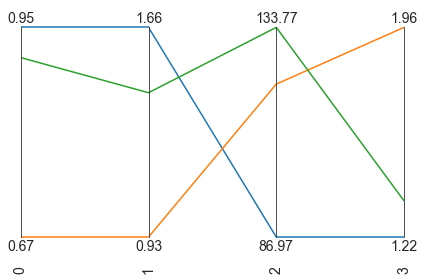

In [72]:
limits = parcoords.get_limits(outcome_stn)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcome_stn)

plt.show()

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the performance of a no-regret (i.e. best possible result in that scenario) policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [132]:
def max_regret(results):
    
    max_P = outcomes['max_P']
    utility = outcomes['utility']
    inertia = outcomes['inertia']
    reliability = outcomes['reliability']
    
    mr_max_P = []
    mr_utility = []
    mr_inertia = []
    mr_reliability = []
    
    for i in range(1,int(len(outcomes['max_P'])/1000)+1):
        mr_max_P.append((max_P - outcomes['max_P'].min()).max())
        mr_utility.append((abs(utility - outcomes['utility'].max())).max())
        mr_inertia.append((abs(inertia - outcomes['inertia'].max())).max())
        mr_reliability.append((abs(reliability - outcomes['reliability'].max())).max())
        
        
    return mr_max_P, mr_utility, mr_inertia, mr_reliability

In [133]:
outcome_mr = pd.DataFrame(max_regret(results)).T

In [134]:
outcome_mr

,0,1,2,3
0,11.04341,2.370855,0.1644,0.99
1,11.04341,2.370855,0.1644,0.99
2,11.04341,2.370855,0.1644,0.99


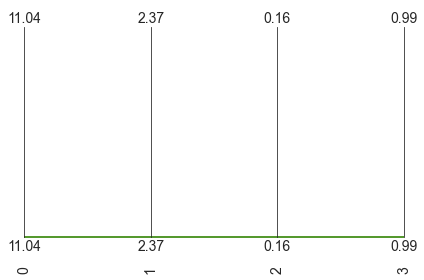

In [136]:
limits = parcoords.get_limits(outcome_mr)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcome_mr)

plt.show()

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. A related but different question is to assess the uncertain conditions under which we get poor performance. For this, we can use scenario discovery. Since we want to identify the uncertainties only, we can remove the policy column from the experiments DataFrame. 

**Perform Scenario Discovery, focussed on understanding the conditions under which utility is lower than 0.25**

from the trade off curve between coverage, density and number of restricted dimensions, select a point which balances them. Next, using the `yi` attribute, select from the experiments data frame the rows which are within the box as well as the outcomes associated with these experiments.Save these results. They are the starting point for the next assignment. In pseudo code:

```python
from ema_workbench import save_results

selected_experiments = experiments.iloc[box.yi]
selected_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

save_results((selected_experiments, selected_outcomes), './results/selected_results.tar.gz')
```





In [189]:
import ema_workbench.analysis.prim as prim
from ema_workbench import save_results, load_results

experiments_SD = experiments.drop(['c1', 'c2', 'r1', 'r2', 'w1', 'policy', 'scenario', 'model'], axis=1)
outcomes_SD = outcomes['utility'] <= 1

[MainProcess/INFO] 3000 points remaining, containing 2522 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.531, coverage: 0.6316415543219667, density: 1.0 restricted_dimensions: 1


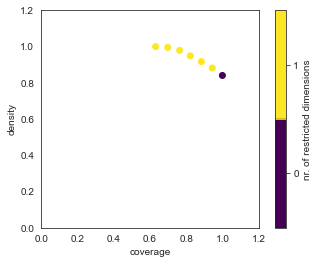

In [190]:
prim_alg = prim.Prim(experiments_SD, outcomes_SD, threshold=0.6, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [191]:
experiments_SD

,b,delta,mean,q,stdev
0,0.159133,0.959376,0.049324,2.040052,0.002658
1,0.272900,0.976112,0.023539,4.011120,0.001843
2,0.128464,0.948733,0.015780,3.864516,0.003414
3,0.312723,0.933572,0.027670,2.359903,0.003359
4,0.235057,0.965641,0.036878,4.274531,0.004929
...,...,...,...,...,...
2995,0.215470,0.982566,0.024942,2.875158,0.002274
2996,0.366197,0.956736,0.039982,3.788697,0.001293
2997,0.318299,0.957168,0.041863,2.335658,0.004876
2998,0.289573,0.933273,0.010902,2.410280,0.004749


In [192]:
outcomes_SD

array([ True,  True,  True, ...,  True,  True, False])

coverage    0.944092
density     0.881852
id                 1
mass             0.9
mean        0.881852
res_dim            1
Name: 1, dtype: object

          box 1                                         
            min       max                      qp values
delta  0.930025  0.983976  [-1.0, 7.486911058295864e-10]



TypeError: select() missing 1 required positional argument: 'i'

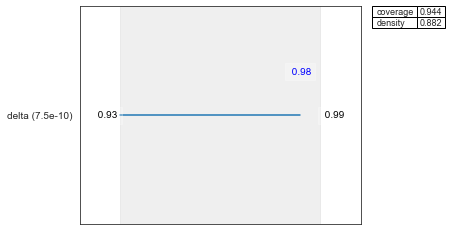

In [186]:
box1.inspect(1)
box1.inspect(1, style='graph')
box1.select(1)
fig = box1.show_pairs_scatter()
plt.show()

In [184]:
selected_experiments = experiments.iloc[box1.yi]
selected_outcomes = {k:v[box1.yi] for k,v in results.items()}
save_results((selected_experiments, selected_outcomes), './selected_results.tar.gz')

AttributeError: 'tuple' object has no attribute 'items'

In [185]:
data_sr = load_results('./selected_results.tar.gz')
data_sr

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\patta\\OneDrive\\Desktop\\Model-based decision making\\HW\\EPA1361_assignments\\Week 5-6 - robustness and direct search\\selected_results.tar.gz'